## Sign-Language Recognition system

## -----------------------------------------------

## Installing libraries

In [1]:
!pip install matplotlib opencv-python tensorflow pandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install labelme

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install pyttsx3

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Checking list of installed libraries
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
bi

## Import packages

In [4]:
import numpy as np  # Linear algebra
import pandas as pd # Data processing (CSV file I/O)
import os   # Operating system
from matplotlib import pyplot as plt
import time # for 'sleep' function
import uuid # for assigning unique ids to images
import csv
from PIL import Image
import random as rand
from sklearn.preprocessing import OneHotEncoder
import pyttsx3

import cv2  # open CV
import keras

## Collection of data

In [5]:
IMAGES_PATH = os.path.join('data', 'images')
labels = ['Hi', 'Ok', 'Go', 'Thank-you']
num_imgs = 10

In [6]:
# Setting up folders

if not os.path.exists(IMAGES_PATH):
    # Makes directory if not existent
    !mkdir {IMAGES_PATH}

for label in labels:
    path = os.path.join(IMAGES_PATH, label)
    if not os.path.exists(path):
        !mkdir {path}


In [31]:
# Capturing images

for label in labels:
    cap = cv2.VideoCapture(0)
    print(f'Collecting images for {label}')
    time.sleep(5)
    for imgnum in range(num_imgs):
        print(f'Collecting image {imgnum}')
        ret, frame = cap.read()
        imgname = os.path.join(IMAGES_PATH, label, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)
        cv2.imshow('frame', frame)
        time.sleep(2)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


In [7]:
# Converting captured images into csv

csv_file_name = 'images_pixels.csv'

data = []
# Open file
with open(csv_file_name, 'w', newline='') as file:
    writer = csv.writer(file)

    # Converting and storing data in csv file
    for i, label in enumerate(labels):
        path = os.path.join(IMAGES_PATH, label)
        for imgs in os.listdir(path):
            img = cv2.imread(os.path.join(IMAGES_PATH, label, imgs))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (240,240))
            img = resized / 255 # Normalize pixel values to be between 1 and 0
            #plt.subplot(111)
            #plt.imshow(resized, cmap='gray')
            data.append([img, i])

            # Writing data to csv file 
            data_csv = label, img.tolist()[0]
            writer.writerow(data)
    


In [8]:
# shuffling data and splitting into train and test data

rand.shuffle(data)

x_data = []
y_data = []

x_train = []
y_train = []

x_test = []
y_test = []

for img in data:
    x_data.append(img[0])
    y_data.append(int(img[1]))
    

# Convert to numpy array
x_data = np.array(x_data)
y_data = np.array(y_data)

#enc = OneHotEncoder(handle_unknown='ignore')
#enc.fit(y_data)

x_data = x_data.reshape((-1, 240, 240, 1))

# 80% data being used for training and 20% for testing
split = int(0.8 * len(data))

x_train = x_data[:split]
y_train = y_data[:split]
x_test = x_data[split:]
y_test = y_data[split:]


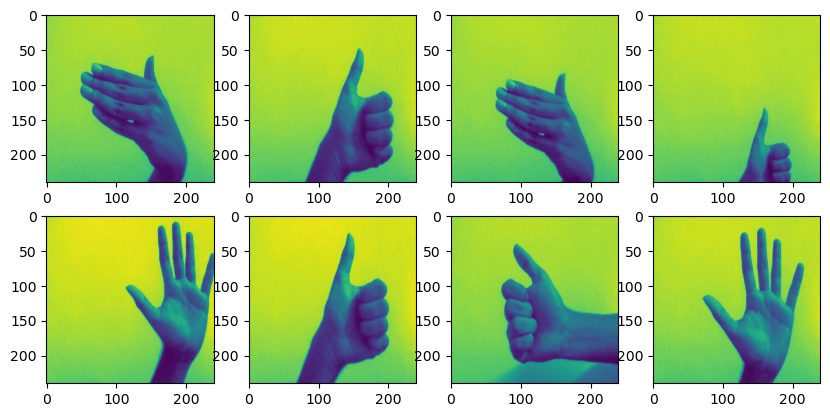

In [9]:
# displaying the first 8 images in our training data
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(4,4, i+1)
    plt.imshow(x_train[i])

In [10]:
""" Result Should Be Like: 
        X Shape: (<Number Of Images>, <Widht Per Image>, <Height Per Image>, <Color Bands> 
        Y Shape: (<Number Of Images>,)
"""

print("X Train Shape: " + str(x_train.shape))
print("Y Train Shape:" + str(y_train.shape))
print("X Test Shape: " + str(x_test.shape))
print("Y Test Shape:" + str(y_test.shape))

X Train Shape: (40, 240, 240, 1)
Y Train Shape:(40,)
X Test Shape: (10, 240, 240, 1)
Y Test Shape:(10,)


## CNN Model


In [11]:
model = keras.models.Sequential([])

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(240,240,1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(units=4, activation='softmax'))
#model.add(keras.layers.CategoryEncoding(num_tokens=4, output_mode="one_hot"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 240, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 230400)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [12]:
# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [30]:
# Train the model
model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
2/2 [==============================] - 2s 558ms/step - loss: 0.0448 - accuracy: 1.0000 - val_loss: 1.3800 - val_accuracy: 0.6000
Epoch 2/20
2/2 [==============================] - 2s 539ms/step - loss: 0.0283 - accuracy: 1.0000 - val_loss: 1.4977 - val_accuracy: 0.6000
Epoch 3/20
2/2 [==============================] - 2s 537ms/step - loss: 0.0168 - accuracy: 1.0000 - val_loss: 1.6830 - val_accuracy: 0.6000
Epoch 4/20
2/2 [==============================] - 2s 538ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 1.9386 - val_accuracy: 0.6000
Epoch 5/20
2/2 [==============================] - 2s 554ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 2.2526 - val_accuracy: 0.6000
Epoch 6/20
2/2 [==============================] - 2s 555ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.4868 - val_accuracy: 0.6000
Epoch 7/20
2/2 [==============================] - 2s 555ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.6559 - val_accuracy: 0.6000
Epoch 8/20
2/2 [====

In [32]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 [==============================] - 0s 86ms/step - loss: 3.2130 - accuracy: 0.6000
Test Loss: 3.2130
Test Accuracy: 0.6000


## Validating

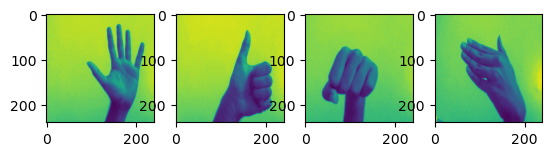

In [33]:
# Reads the directory the pre-processing the data

predictionArr = []
path = os.path.join(IMAGES_PATH, 'test')
for imgs in os.listdir(path):
    img_test = cv2.imread(os.path.join(path, imgs))
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
    img_test = cv2.resize(img_test, (240, 240))
    img_test = img_test / 255
    predictionArr.append(img_test)    
    
predictionArr = np.array(predictionArr)
predictionArr = predictionArr.reshape((-1, 240, 240, 1))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(predictionArr[i])

In [40]:
predictionArr.shape

(4, 240, 240, 1)

In [35]:
# Predicting each picture in the directory
test_prediction = []
test_prediction = model.predict(predictionArr)
for i in range(4):
    index = int(np.argmax(test_prediction[i]))
    print("Prediction: " + labels[index])

1/1 [==============================] - 0s 49ms/step
Prediction: Hi
Prediction: Ok
Prediction: Go
Prediction: Thank-you


## Implementation

In [36]:
VAL_PATH = os.path.join(IMAGES_PATH, 'val')

In [43]:
# Taking image to predict

cam = cv2.VideoCapture(0)
print(f'Taking image!')
time.sleep(3)
ret, frame = cam.read()

while(True):
    ret, frame = cam.read()
    cv2.imshow('Sign-Language Recognition system',frame) #display the captured image
    if cv2.waitKey(1) & 0xFF == ord('q'): #save on pressing 'q' 
        imgname = os.path.join(VAL_PATH, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)
        time.sleep(2)
        cv2.destroyAllWindows()
        break

        
cam.release()

Taking image!


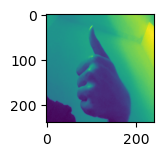

In [44]:
# Reading the taken image

input_img = []
for imgs in os.listdir(VAL_PATH):
    img_val = cv2.imread(os.path.join(VAL_PATH, imgs))
    img_val = cv2.cvtColor(img_val, cv2.COLOR_BGR2GRAY)
    img_val = cv2.resize(img_val, (240, 240))
    img_val = img_val / 255
    input_img.append(img_val)    
    
input_img = np.array(input_img)
input_img = input_img.reshape((-1, 240, 240, 1))

plt.subplot(1,4,1)
plt.imshow(input_img[0])

In [45]:
# Predicting the image

input_img = model.predict(input_img)
index = int(np.argmax(input_img[0]))
print("Prediction: " + labels[index])

1/1 [==============================] - 0s 41ms/step
Prediction: Ok


In [47]:
# Speaking the predicted sign

engine = pyttsx3.init()

engine.setProperty('rate', 150)  # Speed of speech, words per minute

# Text to be spoken
text = "The predicted value is " + labels[index]

# Speak the text
engine.say(text)
engine.runAndWait()


In [42]:
# loop through all files in the directory and remove them
for f in os.listdir(VAL_PATH):
    file_path = os.path.join(VAL_PATH, f)
    if os.path.isfile(file_path):
        os.remove(file_path)

print(f"All files have been removed from {VAL_PATH}")

All files have been removed from data\images\val
